# About

- `Title:` "Lower and Upper Bounds on the VC-Dimension of Tensor Network Models"
- `Main Author:` Behnoush Khavari
- `Source:` [ArXiv](https://arxiv.org/abs/2106.11827)
- `Publish Date:` 22-06-2021
- `Reviewed Date:` 22-11-2021

## Citation

```latex
@article{khavari2021lower,
  title={Lower and Upper Bounds on the VC-Dimension of Tensor Network Models},
  author={Khavari, Behnoush and Rabusseau, Guillaume},
  journal={arXiv preprint arXiv:2106.11827},
  year={2021}
}
```

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%env JAX_ENABLE_X64=1
%env JAX_PLATFORM_NAME=cpu

env: JAX_ENABLE_X64=1
env: JAX_PLATFORM_NAME=cpu


In [3]:
import jax
import jax.numpy as jnp
from jax.config import config

In [4]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])

In [5]:
from functools import reduce

# Random Data Generation

In [6]:
def random_mps(
    size: int,
    local_dim: int,
    bond_dim: int,
    dtype=jnp.float64,
    seed=0):
    """
    Generate a random MPS where each core tensor
    is draws i.i.d. from a uniform distribution 
    between -1 and 1.

    Input:
    ------
    size:       The size of the MPS
    local_dim:  The local dimension size
    bond_dim:   The bond dimension size
    dtype:      The type of data to return.
    seed:       A random seed.
    """
    # initialize MPS data collection
    mps = []
    
    # initialize PRNGKey
    key = jax.random.PRNGKey(seed)
    
    for i in range(size):
        _, key = jax.random.split(key)
        if i == 0:  # left most tensor
            tensor = jax.random.uniform(
                key, shape=(1, local_dim, bond_dim), minval=-1, maxval=1, dtype=dtype)
        elif i == size-1:  # right most tensor
            tensor = jax.random.uniform(
                key, shape=(bond_dim, local_dim, 1), minval=-1, maxval=1, dtype=dtype)
        else:  # middle tensors
            tensor = jax.random.uniform(
                key, shape=(bond_dim, local_dim, bond_dim), minval=-1, maxval=1, dtype=dtype)
        mps.append(tensor)

    return mps

In [7]:
def random_sample(
    size: int,
    local_dim: int,
    n_factors: int,
    dtype=jnp.float64,
    seed=0):
    """
    Generate random data samples where components
    are drawn i.i.d. from a normal distribution.

    Input:
    ------
    size:           The sample size.
    local_dim:      The dimension each sample.
    n_factors:      The number of factors (equal the size of the MPS).
    dtype:          The type of data to return.
    seed:           A random seed.
    """
    # initialize the collection
    samples = []
    
    # initialize PRNGKey
    key = jax.random.PRNGKey(seed)
    
    for i in range(size):
        x = [] 
        for j in range(n_factors):
            _, key = jax.random.split(key)
            xi = jax.random.normal(
                key, 
                shape=(local_dim,), 
                dtype=dtype)
            x.append(xi)
        samples.append(x)

    return jnp.asarray(samples)

In [8]:
def contract(params, inputs):
    """Contract MPS with data"""
    
    def _contract_core(params, inputs):
        """
        Contract an individual core tensor with data component.
        --W--
          |   = --(Wx)--
          x
        """
        tensors = [jnp.einsum('pqr,q->pr', w, x)
                   for w, x in zip(params, inputs)]
        # full reduction (contraction)
        return reduce(lambda x, y: x @ y, tensors)
    
    return jnp.asarray([_contract_core(params, xs)
                        for xs in inputs])

# Training

In [9]:
import time
import itertools

import numpy.random as npr

from jax import jit, grad
from jax.example_libraries import optimizers

## Constants

In [10]:
# PRNG seed
SEED = 123

# model size
MPS_SIZE = 4
LOCAL_DIM = 4
BOND_DIM = 8
RANK = [2, 4, 6, 8, 10, 12, 14] # as used in the paper

# data sample
TEST_SIZE = 2000
TRAIN_SIZE = range(100, 700+1, 100) #, 1000, 2000, 3000, 4000]

# training params
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100
NUM_REPEATS = 20

## Loss function

In [11]:
def mse(targets, outputs):
    diffs = jnp.power(targets - outputs, 2)
    return jnp.mean(diffs)

def loss(params, data):
    inputs, targets = data
    outputs = contract(params, inputs)
    return mse(targets, outputs)

# computing the gradient wrt the loss
grad_loss = jit(grad(loss, argnums=0))

def gradient_descent_step(params, data, lr):
    grads = grad_loss(params, data)
    params_new = [p - lr * g for p, g in zip(params, grads)]
    return params_new

## Execution

In [12]:
# target MPS model
true_params = random_mps(size=MPS_SIZE, local_dim=LOCAL_DIM, bond_dim=BOND_DIM, seed=SEED)

# generate test samples
test_data = random_sample(size=TEST_SIZE, local_dim=LOCAL_DIM, n_factors=MPS_SIZE, seed=SEED)

# generate outputs by contracting MPS with data
test_targets = contract(true_params, test_data)

In [13]:
from collections import defaultdict

def idict():
    """Infinitely nested dict"""
    return defaultdict(idict)

def idict2dict(dic):
    if isinstance(dic, defaultdict):
        dic = {k: idict2dict(v) for k, v in dic.items()}
    return dic

In [14]:
import os
import pickle

def save_pkl(file_path, data):
    dir_name = os.path.dirname(file_path)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

In [ ]:
time_stamp = time.strftime('%Y%m%d', time.localtime())

In [15]:
# storing results
results = idict()

for rank in RANK:
            
    for train_size in TRAIN_SIZE:

        loss_tr = []
        loss_te = []
                
        for i in range(NUM_REPEATS):
            
            print('-'*40)
            print(f'Rank {rank}; Training size {train_size}; Run {i}')
            print('-'*40)

            # initialize MPS parameters
            params = random_mps(size=MPS_SIZE, local_dim=LOCAL_DIM, bond_dim=rank, seed=SEED+i)

            # generate samples
            train_data = random_sample(size=train_size, local_dim=LOCAL_DIM, n_factors=MPS_SIZE, seed=SEED+i)

            # generate targets by contracting MPS with data
            train_targets = contract(true_params, train_data)

            # counter
            itercount = itertools.count()

            tic = time.time()
            for epoch in range(NUM_EPOCHS):

                params_new = gradient_descent_step(params, (train_data, train_targets), LEARNING_RATE)

                # Generalization risk
                l_tr = loss(params_new, (train_data, train_targets))
                l_te = loss(params_new, (test_data, test_targets))
                
                # Break when things go off track
                if jnp.isnan(l_tr) or (l_tr > 1e+5):
                    break
                if (epoch+1) % 10 == 0:
                    print(f'Epoch: {epoch+1} - Train loss: {l_tr:0.5f}')

                # computing relative error
                rel_err = jnp.sqrt(jnp.mean(
                    jnp.asarray([mse(p, p_new) for p, p_new in zip(params, params_new)])))
                
                if rel_err < 1e-3:
                    print(f"Converged -> relative error = {rel_err:0.5f}")
                    break

                # update the parameters
                params = params_new
    
            # storing errors for each run for statistics
            loss_tr.append(l_tr)
            loss_te.append(l_te)

            # storing parameters during training
            file_path = os.path.join(f'./params/{time_stamp}/{rank}/{train_size}/{i+1}.pkl')
            save_pkl(file_path, params)
            
            # storing train/test loss
            results['train'][rank][train_size][i] = l_tr
            results['test'][rank][train_size][i] = l_te
            
        print('='*40)
        print(f"Time for training size {train_size} - {(time.time() - tic):0.2f} sec")
        print(f'Mean train loss over {NUM_REPEATS} repetitions - {jnp.mean(jnp.asarray(loss_tr)):0.2f}')
        print(f'Mean test loss over {NUM_REPEATS} repetitions - {jnp.mean(jnp.asarray(loss_te)):0.2f}')
        print('='*40)

----------------------------------------
Rank 2; Training size 100; Run 0
----------------------------------------
Epoch: 10 - Train loss: 1836.72462
Epoch: 20 - Train loss: 1796.77249
Epoch: 30 - Train loss: 1737.11860
Epoch: 40 - Train loss: 1642.32348
Epoch: 50 - Train loss: 1504.02321
Epoch: 60 - Train loss: 1315.22172
Epoch: 70 - Train loss: 1115.39871
Epoch: 80 - Train loss: 973.55913
Epoch: 90 - Train loss: 868.48298
Epoch: 100 - Train loss: 797.56017
----------------------------------------
Rank 2; Training size 100; Run 1
----------------------------------------
Epoch: 10 - Train loss: 1241.43195
Epoch: 20 - Train loss: 1206.46855
Epoch: 30 - Train loss: 1166.06745
Epoch: 40 - Train loss: 1122.44429
Epoch: 50 - Train loss: 1080.99296
Epoch: 60 - Train loss: 1045.38497
Epoch: 70 - Train loss: 1013.74074
Epoch: 80 - Train loss: 982.31676
Epoch: 90 - Train loss: 949.31449
Epoch: 100 - Train loss: 914.92580
----------------------------------------
Rank 2; Training size 100; Run 2


Epoch: 70 - Train loss: 1562.77710
Epoch: 80 - Train loss: 1508.93121
Epoch: 90 - Train loss: 1439.24506
Epoch: 100 - Train loss: 1340.92685
----------------------------------------
Rank 2; Training size 100; Run 18
----------------------------------------
Epoch: 10 - Train loss: 987.09819
Epoch: 20 - Train loss: 979.80721
Epoch: 30 - Train loss: 973.38382
Epoch: 40 - Train loss: 967.39682
Epoch: 50 - Train loss: 961.52064
Epoch: 60 - Train loss: 955.46838
Epoch: 70 - Train loss: 948.94248
Epoch: 80 - Train loss: 941.58529
Epoch: 90 - Train loss: 932.91406
Epoch: 100 - Train loss: 922.21913
----------------------------------------
Rank 2; Training size 100; Run 19
----------------------------------------
Epoch: 10 - Train loss: 2076.38119
Epoch: 20 - Train loss: 2059.19085
Epoch: 30 - Train loss: 2042.23480
Epoch: 40 - Train loss: 2021.04623
Epoch: 50 - Train loss: 1987.44251
Epoch: 60 - Train loss: 1920.95627
Epoch: 70 - Train loss: 1763.86524
Epoch: 80 - Train loss: 1438.80769
Epoch:

Epoch: 50 - Train loss: 1800.49553
Epoch: 60 - Train loss: 1782.83472
Epoch: 70 - Train loss: 1762.84368
Epoch: 80 - Train loss: 1740.76982
Epoch: 90 - Train loss: 1717.16843
Epoch: 100 - Train loss: 1692.51625
----------------------------------------
Rank 2; Training size 200; Run 16
----------------------------------------
Epoch: 10 - Train loss: 1675.18845
Epoch: 20 - Train loss: 1623.68027
Epoch: 30 - Train loss: 1568.34257
Epoch: 40 - Train loss: 1499.08657
Epoch: 50 - Train loss: 1406.40367
Epoch: 60 - Train loss: 1286.20082
Epoch: 70 - Train loss: 1151.07377
Epoch: 80 - Train loss: 1024.62105
Epoch: 90 - Train loss: 911.58504
Epoch: 100 - Train loss: 807.77336
----------------------------------------
Rank 2; Training size 200; Run 17
----------------------------------------
Epoch: 10 - Train loss: 1693.41190
Epoch: 20 - Train loss: 1590.96555
Epoch: 30 - Train loss: 1484.17718
Epoch: 40 - Train loss: 1417.93490
Epoch: 50 - Train loss: 1378.38618
Epoch: 60 - Train loss: 1342.0915

Epoch: 70 - Train loss: 1933.57829
Epoch: 80 - Train loss: 1837.51221
Epoch: 90 - Train loss: 1731.59191
Epoch: 100 - Train loss: 1626.55791
----------------------------------------
Rank 2; Training size 300; Run 13
----------------------------------------
Epoch: 10 - Train loss: 1332.03124
Epoch: 20 - Train loss: 1312.40710
Epoch: 30 - Train loss: 1283.96356
Epoch: 40 - Train loss: 1243.78519
Epoch: 50 - Train loss: 1193.45480
Epoch: 60 - Train loss: 1146.19697
Epoch: 70 - Train loss: 1117.77104
Epoch: 80 - Train loss: 1104.88124
Epoch: 90 - Train loss: 1097.05043
Epoch: 100 - Train loss: 1090.14044
----------------------------------------
Rank 2; Training size 300; Run 14
----------------------------------------
Epoch: 10 - Train loss: 1557.29954
Epoch: 20 - Train loss: 1542.05878
Epoch: 30 - Train loss: 1530.91515
Epoch: 40 - Train loss: 1522.28071
Epoch: 50 - Train loss: 1515.25874
Epoch: 60 - Train loss: 1509.29827
Epoch: 70 - Train loss: 1504.03602
Converged -> relative error = 0

Epoch: 10 - Train loss: 2432.95047
Epoch: 20 - Train loss: 2424.84215
Epoch: 30 - Train loss: 2415.66857
Epoch: 40 - Train loss: 2404.39329
Epoch: 50 - Train loss: 2389.40314
Epoch: 60 - Train loss: 2367.92519
Epoch: 70 - Train loss: 2334.85934
Epoch: 80 - Train loss: 2280.56482
Epoch: 90 - Train loss: 2188.43989
Epoch: 100 - Train loss: 2044.61245
----------------------------------------
Rank 2; Training size 400; Run 11
----------------------------------------
Epoch: 10 - Train loss: 1624.66853
Epoch: 20 - Train loss: 1610.74314
Epoch: 30 - Train loss: 1595.00642
Epoch: 40 - Train loss: 1577.31713
Epoch: 50 - Train loss: 1557.73878
Epoch: 60 - Train loss: 1536.61261
Epoch: 70 - Train loss: 1514.54265
Epoch: 80 - Train loss: 1492.22593
Epoch: 90 - Train loss: 1470.17494
Epoch: 100 - Train loss: 1448.52574
----------------------------------------
Rank 2; Training size 400; Run 12
----------------------------------------
Epoch: 10 - Train loss: 2306.29484
Epoch: 20 - Train loss: 2259.22

Epoch: 30 - Train loss: 1767.92148
Epoch: 40 - Train loss: 1744.90126
Epoch: 50 - Train loss: 1717.44523
Epoch: 60 - Train loss: 1683.75570
Epoch: 70 - Train loss: 1641.69901
Epoch: 80 - Train loss: 1589.12406
Epoch: 90 - Train loss: 1524.82366
Epoch: 100 - Train loss: 1450.29364
----------------------------------------
Rank 2; Training size 500; Run 8
----------------------------------------
Epoch: 10 - Train loss: 1987.23848
Epoch: 20 - Train loss: 1953.85112
Epoch: 30 - Train loss: 1918.32440
Epoch: 40 - Train loss: 1882.95891
Epoch: 50 - Train loss: 1851.33624
Epoch: 60 - Train loss: 1825.36172
Epoch: 70 - Train loss: 1803.86473
Epoch: 80 - Train loss: 1784.43232
Epoch: 90 - Train loss: 1765.24136
Epoch: 100 - Train loss: 1745.24232
----------------------------------------
Rank 2; Training size 500; Run 9
----------------------------------------
Epoch: 10 - Train loss: 2211.77347
Epoch: 20 - Train loss: 2175.98533
Epoch: 30 - Train loss: 2149.01380
Epoch: 40 - Train loss: 2125.4168

Epoch: 10 - Train loss: 1968.38839
Epoch: 20 - Train loss: 1953.87336
Epoch: 30 - Train loss: 1935.18264
Epoch: 40 - Train loss: 1909.46597
Epoch: 50 - Train loss: 1872.18336
Epoch: 60 - Train loss: 1816.47535
Epoch: 70 - Train loss: 1734.65000
Epoch: 80 - Train loss: 1628.32499
Epoch: 90 - Train loss: 1525.95100
Epoch: 100 - Train loss: 1458.57373
----------------------------------------
Rank 2; Training size 600; Run 6
----------------------------------------
Epoch: 10 - Train loss: 1763.24212
Epoch: 20 - Train loss: 1746.08621
Epoch: 30 - Train loss: 1732.73355
Epoch: 40 - Train loss: 1721.59493
Epoch: 50 - Train loss: 1711.68667
Epoch: 60 - Train loss: 1702.32464
Epoch: 70 - Train loss: 1692.97016
Epoch: 80 - Train loss: 1683.14043
Epoch: 90 - Train loss: 1672.34696
Epoch: 100 - Train loss: 1660.04461
----------------------------------------
Rank 2; Training size 600; Run 7
----------------------------------------
Epoch: 10 - Train loss: 1768.16851
Epoch: 20 - Train loss: 1752.0606

Epoch: 60 - Train loss: 2745.80309
Epoch: 70 - Train loss: 2732.07696
Epoch: 80 - Train loss: 2716.48794
Epoch: 90 - Train loss: 2698.22300
Epoch: 100 - Train loss: 2676.46381
----------------------------------------
Rank 2; Training size 700; Run 3
----------------------------------------
Epoch: 10 - Train loss: 1895.94140
Epoch: 20 - Train loss: 1870.68053
Epoch: 30 - Train loss: 1847.72543
Epoch: 40 - Train loss: 1824.88973
Epoch: 50 - Train loss: 1800.90516
Epoch: 60 - Train loss: 1775.08470
Epoch: 70 - Train loss: 1747.21687
Epoch: 80 - Train loss: 1717.45974
Epoch: 90 - Train loss: 1686.11471
Epoch: 100 - Train loss: 1653.32918
----------------------------------------
Rank 2; Training size 700; Run 4
----------------------------------------
Epoch: 10 - Train loss: 2220.33092
Epoch: 20 - Train loss: 2202.55497
Epoch: 30 - Train loss: 2179.60365
Epoch: 40 - Train loss: 2148.18295
Epoch: 50 - Train loss: 2103.02927
Epoch: 60 - Train loss: 2035.87337
Epoch: 70 - Train loss: 1935.7840

Epoch: 10 - Train loss: 1526.61108
Epoch: 20 - Train loss: 1308.68992
Epoch: 30 - Train loss: 1142.34605
Epoch: 40 - Train loss: 979.25146
Epoch: 50 - Train loss: 828.21491
Epoch: 60 - Train loss: 704.56777
Epoch: 70 - Train loss: 608.83410
Epoch: 80 - Train loss: 534.18094
Epoch: 90 - Train loss: 475.99286
Epoch: 100 - Train loss: 431.26657
----------------------------------------
Rank 4; Training size 100; Run 1
----------------------------------------
Epoch: 10 - Train loss: 1152.77312
Epoch: 20 - Train loss: 986.04221
Epoch: 30 - Train loss: 876.09205
Epoch: 40 - Train loss: 790.56667
Epoch: 50 - Train loss: 716.08045
Epoch: 60 - Train loss: 646.75229
Epoch: 70 - Train loss: 579.99508
Epoch: 80 - Train loss: 516.89189
Epoch: 90 - Train loss: 461.47174
Epoch: 100 - Train loss: 416.98703
----------------------------------------
Rank 4; Training size 100; Run 2
----------------------------------------
Epoch: 10 - Train loss: 1292.09162
Epoch: 20 - Train loss: 1212.65516
Epoch: 30 - Tr

Epoch: 10 - Train loss: 1013.96654
Epoch: 20 - Train loss: 958.59169
Epoch: 30 - Train loss: 917.07100
Epoch: 40 - Train loss: 881.88827
Epoch: 50 - Train loss: 849.29175
Epoch: 60 - Train loss: 816.78146
Epoch: 70 - Train loss: 782.08842
Epoch: 80 - Train loss: 742.54644
Epoch: 90 - Train loss: 694.48285
Epoch: 100 - Train loss: 632.69430
----------------------------------------
Rank 4; Training size 100; Run 19
----------------------------------------
Epoch: 10 - Train loss: 1755.74309
Epoch: 20 - Train loss: 1225.57619
Epoch: 30 - Train loss: 797.58656
Epoch: 40 - Train loss: 636.39433
Epoch: 50 - Train loss: 562.02103
Epoch: 60 - Train loss: 517.78110
Epoch: 70 - Train loss: 485.93336
Epoch: 80 - Train loss: 460.59952
Epoch: 90 - Train loss: 439.20483
Epoch: 100 - Train loss: 420.41208
Time for training size 100 - 79.52 sec
Mean train loss over 20 repetitions - 413.16
Mean test loss over 20 repetitions - 2259.66
----------------------------------------
Rank 4; Training size 200; Ru

Epoch: 60 - Train loss: 794.64011
Epoch: 70 - Train loss: 696.28842
Epoch: 80 - Train loss: 631.78062
Epoch: 90 - Train loss: 585.11009
Epoch: 100 - Train loss: 547.38478
----------------------------------------
Rank 4; Training size 200; Run 16
----------------------------------------
Epoch: 10 - Train loss: 1585.10080
Epoch: 20 - Train loss: 1479.83526
Epoch: 30 - Train loss: 1344.37945
Epoch: 40 - Train loss: 1179.40930
Epoch: 50 - Train loss: 1024.71292
Epoch: 60 - Train loss: 905.09094
Epoch: 70 - Train loss: 813.09220
Epoch: 80 - Train loss: 742.27192
Epoch: 90 - Train loss: 686.73512
Epoch: 100 - Train loss: 640.99519
----------------------------------------
Rank 4; Training size 200; Run 17
----------------------------------------
Epoch: 10 - Train loss: 1389.81106
Epoch: 20 - Train loss: 1270.34716
Epoch: 30 - Train loss: 1148.70153
Epoch: 40 - Train loss: 1016.63546
Epoch: 50 - Train loss: 885.13357
Epoch: 60 - Train loss: 768.38920
Epoch: 70 - Train loss: 670.71043
Epoch: 80

Epoch: 100 - Train loss: 686.57833
----------------------------------------
Rank 4; Training size 300; Run 13
----------------------------------------
Epoch: 10 - Train loss: 1369.96012
Epoch: 20 - Train loss: 1266.59854
Epoch: 30 - Train loss: 1195.88152
Epoch: 40 - Train loss: 1142.11696
Epoch: 50 - Train loss: 1094.97590
Epoch: 60 - Train loss: 1048.95950
Epoch: 70 - Train loss: 1001.18162
Epoch: 80 - Train loss: 950.18819
Epoch: 90 - Train loss: 895.76633
Epoch: 100 - Train loss: 838.97750
----------------------------------------
Rank 4; Training size 300; Run 14
----------------------------------------
Epoch: 10 - Train loss: 1346.80428
Epoch: 20 - Train loss: 1249.62562
Epoch: 30 - Train loss: 1173.45938
Epoch: 40 - Train loss: 1103.85280
Epoch: 50 - Train loss: 1035.80937
Epoch: 60 - Train loss: 969.76493
Epoch: 70 - Train loss: 909.27148
Epoch: 80 - Train loss: 857.14531
Epoch: 90 - Train loss: 812.85199
Epoch: 100 - Train loss: 773.83179
---------------------------------------

Epoch: 10 - Train loss: 2179.99132
Epoch: 20 - Train loss: 1784.56034
Epoch: 30 - Train loss: 1550.70861
Epoch: 40 - Train loss: 1420.00662
Epoch: 50 - Train loss: 1305.19859
Epoch: 60 - Train loss: 1198.44848
Epoch: 70 - Train loss: 1099.18068
Epoch: 80 - Train loss: 1008.44328
Epoch: 90 - Train loss: 928.75901
Epoch: 100 - Train loss: 862.48845
----------------------------------------
Rank 4; Training size 400; Run 11
----------------------------------------
Epoch: 10 - Train loss: 1599.07356
Epoch: 20 - Train loss: 1417.42839
Epoch: 30 - Train loss: 1285.33418
Epoch: 40 - Train loss: 1185.84209
Epoch: 50 - Train loss: 1101.53394
Epoch: 60 - Train loss: 1021.77438
Epoch: 70 - Train loss: 944.28466
Epoch: 80 - Train loss: 870.38113
Epoch: 90 - Train loss: 802.02343
Epoch: 100 - Train loss: 740.54451
----------------------------------------
Rank 4; Training size 400; Run 12
----------------------------------------
Epoch: 10 - Train loss: 2202.87080
Epoch: 20 - Train loss: 2043.01498
Ep

Epoch: 40 - Train loss: 1390.33220
Epoch: 50 - Train loss: 1306.00590
Epoch: 60 - Train loss: 1244.36512
Epoch: 70 - Train loss: 1198.11948
Epoch: 80 - Train loss: 1161.03988
Epoch: 90 - Train loss: 1129.65881
Epoch: 100 - Train loss: 1102.09650
----------------------------------------
Rank 4; Training size 500; Run 8
----------------------------------------
Epoch: 10 - Train loss: 2013.00819
Epoch: 20 - Train loss: 1844.19861
Epoch: 30 - Train loss: 1694.21806
Epoch: 40 - Train loss: 1554.17448
Epoch: 50 - Train loss: 1435.41364
Epoch: 60 - Train loss: 1335.65650
Epoch: 70 - Train loss: 1241.36251
Epoch: 80 - Train loss: 1144.14440
Epoch: 90 - Train loss: 1042.39488
Epoch: 100 - Train loss: 938.93890
----------------------------------------
Rank 4; Training size 500; Run 9
----------------------------------------
Epoch: 10 - Train loss: 2152.75410
Epoch: 20 - Train loss: 2058.55601
Epoch: 30 - Train loss: 1978.56280
Epoch: 40 - Train loss: 1884.78680
Epoch: 50 - Train loss: 1758.99605

Epoch: 70 - Train loss: 1134.42680
Epoch: 80 - Train loss: 1001.68750
Epoch: 90 - Train loss: 880.38897
Epoch: 100 - Train loss: 767.34979
----------------------------------------
Rank 4; Training size 600; Run 5
----------------------------------------
Epoch: 10 - Train loss: 1837.91178
Epoch: 20 - Train loss: 1695.88547
Epoch: 30 - Train loss: 1578.77733
Epoch: 40 - Train loss: 1474.63351
Epoch: 50 - Train loss: 1383.91289
Epoch: 60 - Train loss: 1306.74475
Epoch: 70 - Train loss: 1240.79142
Epoch: 80 - Train loss: 1182.68496
Epoch: 90 - Train loss: 1129.03708
Epoch: 100 - Train loss: 1077.02447
----------------------------------------
Rank 4; Training size 600; Run 6
----------------------------------------
Epoch: 10 - Train loss: 1817.27742
Epoch: 20 - Train loss: 1694.39409
Epoch: 30 - Train loss: 1608.59398
Epoch: 40 - Train loss: 1531.98688
Epoch: 50 - Train loss: 1459.13430
Epoch: 60 - Train loss: 1392.37166
Epoch: 70 - Train loss: 1334.50752
Epoch: 80 - Train loss: 1284.97810


Epoch: 100 - Train loss: 1221.97200
----------------------------------------
Rank 4; Training size 700; Run 2
----------------------------------------
Epoch: 10 - Train loss: 2525.82328
Epoch: 20 - Train loss: 2056.96435
Epoch: 30 - Train loss: 1477.31083
Epoch: 40 - Train loss: 1286.31293
Epoch: 50 - Train loss: 1173.32257
Epoch: 60 - Train loss: 1097.80112
Epoch: 70 - Train loss: 1042.82564
Epoch: 80 - Train loss: 998.38979
Epoch: 90 - Train loss: 959.77150
Epoch: 100 - Train loss: 924.88433
----------------------------------------
Rank 4; Training size 700; Run 3
----------------------------------------
Epoch: 10 - Train loss: 1940.79052
Epoch: 20 - Train loss: 1825.16048
Epoch: 30 - Train loss: 1745.39476
Epoch: 40 - Train loss: 1675.52517
Epoch: 50 - Train loss: 1608.31175
Epoch: 60 - Train loss: 1543.72860
Epoch: 70 - Train loss: 1484.33357
Epoch: 80 - Train loss: 1431.49308
Epoch: 90 - Train loss: 1384.46362
Epoch: 100 - Train loss: 1341.75004
-----------------------------------

Epoch: 50 - Train loss: 1848.05785
Epoch: 60 - Train loss: 1778.76228
Epoch: 70 - Train loss: 1714.35541
Epoch: 80 - Train loss: 1653.26330
Epoch: 90 - Train loss: 1593.06728
Epoch: 100 - Train loss: 1531.64515
Time for training size 700 - 102.17 sec
Mean train loss over 20 repetitions - 1065.45
Mean test loss over 20 repetitions - 1637.47
----------------------------------------
Rank 6; Training size 100; Run 0
----------------------------------------
Epoch: 10 - Train loss: 1365.70460
Epoch: 20 - Train loss: 970.73399
Epoch: 30 - Train loss: 722.14171
Epoch: 40 - Train loss: 541.77012
Epoch: 50 - Train loss: 424.81725
Epoch: 60 - Train loss: 354.31695
Epoch: 70 - Train loss: 307.31701
Epoch: 80 - Train loss: 270.77414
Epoch: 90 - Train loss: 240.18496
Epoch: 100 - Train loss: 214.08210
----------------------------------------
Rank 6; Training size 100; Run 1
----------------------------------------
Epoch: 10 - Train loss: 1003.51338
Epoch: 20 - Train loss: 747.03207
Epoch: 30 - Train

Epoch: 70 - Train loss: 394.82053
Epoch: 80 - Train loss: 357.18840
Epoch: 90 - Train loss: 327.10306
Converged -> relative error = 0.00100
----------------------------------------
Rank 6; Training size 100; Run 18
----------------------------------------
Epoch: 10 - Train loss: 791.81412
Epoch: 20 - Train loss: 536.46667
Epoch: 30 - Train loss: 403.14998
Epoch: 40 - Train loss: 336.18510
Epoch: 50 - Train loss: 289.89113
Epoch: 60 - Train loss: 256.52589
Epoch: 70 - Train loss: 232.47233
Converged -> relative error = 0.00099
----------------------------------------
Rank 6; Training size 100; Run 19
----------------------------------------
Epoch: 10 - Train loss: 907.48970
Epoch: 20 - Train loss: 548.04855
Epoch: 30 - Train loss: 429.60887
Epoch: 40 - Train loss: 363.95575
Epoch: 50 - Train loss: 318.37170
Epoch: 60 - Train loss: 283.76256
Converged -> relative error = 0.00100
Time for training size 100 - 55.24 sec
Mean train loss over 20 repetitions - 232.75
Mean test loss over 20 rep

Epoch: 60 - Train loss: 632.03850
Epoch: 70 - Train loss: 553.31681
Epoch: 80 - Train loss: 490.29436
Epoch: 90 - Train loss: 438.73228
Epoch: 100 - Train loss: 395.77258
----------------------------------------
Rank 6; Training size 200; Run 16
----------------------------------------
Epoch: 10 - Train loss: 1083.95007
Epoch: 20 - Train loss: 828.80003
Epoch: 30 - Train loss: 680.38195
Epoch: 40 - Train loss: 584.22859
Epoch: 50 - Train loss: 513.09364
Epoch: 60 - Train loss: 455.19673
Epoch: 70 - Train loss: 406.43871
Epoch: 80 - Train loss: 365.30351
Epoch: 90 - Train loss: 330.80783
Epoch: 100 - Train loss: 301.91600
----------------------------------------
Rank 6; Training size 200; Run 17
----------------------------------------
Epoch: 10 - Train loss: 1587.87454
Epoch: 20 - Train loss: 1371.67961
Epoch: 30 - Train loss: 1225.12710
Epoch: 40 - Train loss: 1094.96088
Epoch: 50 - Train loss: 967.06811
Epoch: 60 - Train loss: 839.98581
Epoch: 70 - Train loss: 719.13510
Epoch: 80 - T

Epoch: 10 - Train loss: 1472.86414
Epoch: 20 - Train loss: 1275.15008
Epoch: 30 - Train loss: 1139.10293
Epoch: 40 - Train loss: 1017.10517
Epoch: 50 - Train loss: 925.63174
Epoch: 60 - Train loss: 856.63161
Epoch: 70 - Train loss: 794.69582
Epoch: 80 - Train loss: 734.73505
Epoch: 90 - Train loss: 675.72247
Epoch: 100 - Train loss: 618.29139
----------------------------------------
Rank 6; Training size 300; Run 14
----------------------------------------
Epoch: 10 - Train loss: 1556.01315
Epoch: 20 - Train loss: 1393.95720
Epoch: 30 - Train loss: 1273.92471
Epoch: 40 - Train loss: 1164.00165
Epoch: 50 - Train loss: 1057.27726
Epoch: 60 - Train loss: 956.01134
Epoch: 70 - Train loss: 863.79774
Epoch: 80 - Train loss: 781.08664
Epoch: 90 - Train loss: 706.45376
Epoch: 100 - Train loss: 639.22593
----------------------------------------
Rank 6; Training size 300; Run 15
----------------------------------------
Epoch: 10 - Train loss: 1696.11205
Epoch: 20 - Train loss: 1334.40763
Epoch: 

Epoch: 60 - Train loss: 529.06736
Epoch: 70 - Train loss: 455.05035
Epoch: 80 - Train loss: 405.48774
Epoch: 90 - Train loss: 370.40203
Epoch: 100 - Train loss: 344.11275
----------------------------------------
Rank 6; Training size 400; Run 11
----------------------------------------
Epoch: 10 - Train loss: 1433.70926
Epoch: 20 - Train loss: 1227.15306
Epoch: 30 - Train loss: 1090.68979
Epoch: 40 - Train loss: 975.56436
Epoch: 50 - Train loss: 873.10138
Epoch: 60 - Train loss: 781.79544
Epoch: 70 - Train loss: 701.71166
Epoch: 80 - Train loss: 632.87596
Epoch: 90 - Train loss: 574.46536
Epoch: 100 - Train loss: 524.86976
----------------------------------------
Rank 6; Training size 400; Run 12
----------------------------------------
Epoch: 10 - Train loss: 1934.54801
Epoch: 20 - Train loss: 1515.55660
Epoch: 30 - Train loss: 1296.37153
Epoch: 40 - Train loss: 1146.99583
Epoch: 50 - Train loss: 1025.11817
Epoch: 60 - Train loss: 922.16817
Epoch: 70 - Train loss: 835.31998
Epoch: 80 

Epoch: 100 - Train loss: 566.34946
----------------------------------------
Rank 6; Training size 500; Run 8
----------------------------------------
Epoch: 10 - Train loss: 1556.22864
Epoch: 20 - Train loss: 1196.33710
Epoch: 30 - Train loss: 962.16081
Epoch: 40 - Train loss: 797.86951
Epoch: 50 - Train loss: 678.82005
Epoch: 60 - Train loss: 588.26636
Epoch: 70 - Train loss: 517.10372
Epoch: 80 - Train loss: 459.43203
Epoch: 90 - Train loss: 411.32433
Epoch: 100 - Train loss: 370.37578
----------------------------------------
Rank 6; Training size 500; Run 9
----------------------------------------
Epoch: 10 - Train loss: 1804.40668
Epoch: 20 - Train loss: 1394.84122
Epoch: 30 - Train loss: 1156.80556
Epoch: 40 - Train loss: 1022.33559
Epoch: 50 - Train loss: 922.74654
Epoch: 60 - Train loss: 842.03548
Epoch: 70 - Train loss: 777.08924
Epoch: 80 - Train loss: 725.19940
Epoch: 90 - Train loss: 682.55723
Epoch: 100 - Train loss: 645.73630
----------------------------------------
Rank 6

Epoch: 10 - Train loss: 1888.13408
Epoch: 20 - Train loss: 1534.73363
Epoch: 30 - Train loss: 1323.95735
Epoch: 40 - Train loss: 1186.55376
Epoch: 50 - Train loss: 1075.90889
Epoch: 60 - Train loss: 978.98297
Epoch: 70 - Train loss: 892.43615
Epoch: 80 - Train loss: 815.73098
Epoch: 90 - Train loss: 748.67199
Epoch: 100 - Train loss: 690.54858
----------------------------------------
Rank 6; Training size 600; Run 6
----------------------------------------
Epoch: 10 - Train loss: 1714.59768
Epoch: 20 - Train loss: 1476.56756
Epoch: 30 - Train loss: 1300.30089
Epoch: 40 - Train loss: 1138.87369
Epoch: 50 - Train loss: 992.14648
Epoch: 60 - Train loss: 868.49444
Epoch: 70 - Train loss: 770.20287
Epoch: 80 - Train loss: 693.68175
Epoch: 90 - Train loss: 633.57387
Epoch: 100 - Train loss: 584.84744
----------------------------------------
Rank 6; Training size 600; Run 7
----------------------------------------
Epoch: 10 - Train loss: 1544.44949
Epoch: 20 - Train loss: 1274.62812
Epoch: 30

Epoch: 60 - Train loss: 987.96867
Epoch: 70 - Train loss: 873.66133
Epoch: 80 - Train loss: 784.75902
Epoch: 90 - Train loss: 712.91907
Epoch: 100 - Train loss: 653.62291
----------------------------------------
Rank 6; Training size 700; Run 3
----------------------------------------
Epoch: 10 - Train loss: 2052.50867
Epoch: 20 - Train loss: 1800.27259
Epoch: 30 - Train loss: 1627.77373
Epoch: 40 - Train loss: 1470.81924
Epoch: 50 - Train loss: 1321.96817
Epoch: 60 - Train loss: 1182.17402
Epoch: 70 - Train loss: 1050.90114
Epoch: 80 - Train loss: 929.65566
Epoch: 90 - Train loss: 822.61736
Epoch: 100 - Train loss: 732.59750
----------------------------------------
Rank 6; Training size 700; Run 4
----------------------------------------
Epoch: 10 - Train loss: 2127.09924
Epoch: 20 - Train loss: 1803.89448
Epoch: 30 - Train loss: 1463.13113
Epoch: 40 - Train loss: 1159.51973
Epoch: 50 - Train loss: 976.29727
Epoch: 60 - Train loss: 858.78997
Epoch: 70 - Train loss: 770.16408
Epoch: 80

Converged -> relative error = 0.00000
----------------------------------------
Rank 8; Training size 100; Run 1
----------------------------------------
Epoch: 10 - Train loss: 894.23892
Epoch: 20 - Train loss: 640.30251
Epoch: 30 - Train loss: 496.88046
Epoch: 40 - Train loss: 403.89640
Epoch: 50 - Train loss: 342.54470
Epoch: 60 - Train loss: 299.18751
Converged -> relative error = 0.00100
----------------------------------------
Rank 8; Training size 100; Run 2
----------------------------------------
Epoch: 10 - Train loss: 797.72186
Epoch: 20 - Train loss: 490.52618
Epoch: 30 - Train loss: 347.37291
Epoch: 40 - Train loss: 272.22251
Epoch: 50 - Train loss: 224.23458
Epoch: 60 - Train loss: 190.74187
Converged -> relative error = 0.00099
----------------------------------------
Rank 8; Training size 100; Run 3
----------------------------------------
Epoch: 10 - Train loss: 944.82555
Epoch: 20 - Train loss: 632.79624
Epoch: 30 - Train loss: 482.76390
Epoch: 40 - Train loss: 384.213

Epoch: 70 - Train loss: 314.66877
Converged -> relative error = 0.00099
----------------------------------------
Rank 8; Training size 200; Run 3
----------------------------------------
Epoch: 10 - Train loss: 1382.69534
Epoch: 20 - Train loss: 1001.23842
Epoch: 30 - Train loss: 794.19064
Epoch: 40 - Train loss: 649.11753
Epoch: 50 - Train loss: 538.60903
Epoch: 60 - Train loss: 454.43850
Epoch: 70 - Train loss: 392.59952
Epoch: 80 - Train loss: 348.27583
Converged -> relative error = 0.00100
----------------------------------------
Rank 8; Training size 200; Run 4
----------------------------------------
Epoch: 10 - Train loss: 1411.53447
Epoch: 20 - Train loss: 854.22049
Epoch: 30 - Train loss: 684.37045
Epoch: 40 - Train loss: 595.04969
Epoch: 50 - Train loss: 525.67778
Epoch: 60 - Train loss: 464.62911
Epoch: 70 - Train loss: 409.61031
Epoch: 80 - Train loss: 360.76895
Epoch: 90 - Train loss: 318.59065
Epoch: 100 - Train loss: 283.08927
----------------------------------------
Ran

Epoch: 30 - Train loss: 935.86963
Epoch: 40 - Train loss: 759.03930
Epoch: 50 - Train loss: 637.20077
Epoch: 60 - Train loss: 546.69370
Epoch: 70 - Train loss: 476.86788
Epoch: 80 - Train loss: 421.56334
Epoch: 90 - Train loss: 376.82991
Epoch: 100 - Train loss: 340.01805
----------------------------------------
Rank 8; Training size 300; Run 2
----------------------------------------
Epoch: 10 - Train loss: 1353.67547
Epoch: 20 - Train loss: 985.12817
Epoch: 30 - Train loss: 780.54749
Epoch: 40 - Train loss: 651.71721
Epoch: 50 - Train loss: 564.39115
Epoch: 60 - Train loss: 500.59122
Epoch: 70 - Train loss: 451.42827
Epoch: 80 - Train loss: 412.18120
Converged -> relative error = 0.00100
----------------------------------------
Rank 8; Training size 300; Run 3
----------------------------------------
Epoch: 10 - Train loss: 1414.54204
Epoch: 20 - Train loss: 1077.04040
Epoch: 30 - Train loss: 899.31261
Epoch: 40 - Train loss: 774.27929
Epoch: 50 - Train loss: 675.79660
Epoch: 60 - Tr

Epoch: 70 - Train loss: 466.07205
Epoch: 80 - Train loss: 427.14559
Epoch: 90 - Train loss: 393.84794
Epoch: 100 - Train loss: 364.31513
Time for training size 300 - 87.58 sec
Mean train loss over 20 repetitions - 353.41
Mean test loss over 20 repetitions - 1610.71
----------------------------------------
Rank 8; Training size 400; Run 0
----------------------------------------
Converged -> relative error = 0.00000
----------------------------------------
Rank 8; Training size 400; Run 1
----------------------------------------
Epoch: 10 - Train loss: 1951.60909
Epoch: 20 - Train loss: 1338.55912
Epoch: 30 - Train loss: 1021.19841
Epoch: 40 - Train loss: 839.74979
Epoch: 50 - Train loss: 720.44372
Epoch: 60 - Train loss: 633.96137
Epoch: 70 - Train loss: 567.00189
Epoch: 80 - Train loss: 512.56660
Epoch: 90 - Train loss: 466.68984
Epoch: 100 - Train loss: 427.07166
----------------------------------------
Rank 8; Training size 400; Run 2
----------------------------------------
Epoch: 

Epoch: 10 - Train loss: 1610.81284
Epoch: 20 - Train loss: 1382.59234
Epoch: 30 - Train loss: 1215.25426
Epoch: 40 - Train loss: 1065.64224
Epoch: 50 - Train loss: 925.38176
Epoch: 60 - Train loss: 797.05140
Epoch: 70 - Train loss: 690.17942
Epoch: 80 - Train loss: 609.78011
Epoch: 90 - Train loss: 551.41580
Epoch: 100 - Train loss: 508.06208
----------------------------------------
Rank 8; Training size 400; Run 19
----------------------------------------
Epoch: 10 - Train loss: 1368.68598
Epoch: 20 - Train loss: 998.05960
Epoch: 30 - Train loss: 811.19344
Epoch: 40 - Train loss: 695.75613
Epoch: 50 - Train loss: 612.06356
Epoch: 60 - Train loss: 544.61089
Epoch: 70 - Train loss: 487.00479
Epoch: 80 - Train loss: 436.23688
Epoch: 90 - Train loss: 390.79053
Epoch: 100 - Train loss: 349.91310
Time for training size 400 - 92.47 sec
Mean train loss over 20 repetitions - 391.59
Mean test loss over 20 repetitions - 1384.12
----------------------------------------
Rank 8; Training size 500; 

Epoch: 50 - Train loss: 705.33355
Epoch: 60 - Train loss: 615.23562
Epoch: 70 - Train loss: 546.35289
Epoch: 80 - Train loss: 491.96707
Epoch: 90 - Train loss: 448.37008
Epoch: 100 - Train loss: 412.89632
----------------------------------------
Rank 8; Training size 500; Run 17
----------------------------------------
Epoch: 10 - Train loss: 1666.43557
Epoch: 20 - Train loss: 1256.77226
Epoch: 30 - Train loss: 1075.22511
Epoch: 40 - Train loss: 959.61817
Epoch: 50 - Train loss: 867.26770
Epoch: 60 - Train loss: 786.69018
Epoch: 70 - Train loss: 714.72724
Epoch: 80 - Train loss: 651.18008
Epoch: 90 - Train loss: 596.17998
Epoch: 100 - Train loss: 549.01999
----------------------------------------
Rank 8; Training size 500; Run 18
----------------------------------------
Epoch: 10 - Train loss: 1673.79992
Epoch: 20 - Train loss: 1444.06873
Epoch: 30 - Train loss: 1285.20124
Epoch: 40 - Train loss: 1149.37288
Epoch: 50 - Train loss: 1023.99019
Epoch: 60 - Train loss: 907.24790
Epoch: 70 

Epoch: 80 - Train loss: 597.95074
Epoch: 90 - Train loss: 552.11004
Epoch: 100 - Train loss: 510.25238
----------------------------------------
Rank 8; Training size 600; Run 15
----------------------------------------
Epoch: 10 - Train loss: 2147.51346
Epoch: 20 - Train loss: 1743.68775
Epoch: 30 - Train loss: 1364.60143
Epoch: 40 - Train loss: 1047.14361
Epoch: 50 - Train loss: 846.80068
Epoch: 60 - Train loss: 719.68873
Epoch: 70 - Train loss: 629.13245
Epoch: 80 - Train loss: 558.87369
Epoch: 90 - Train loss: 501.84862
Epoch: 100 - Train loss: 454.69322
----------------------------------------
Rank 8; Training size 600; Run 16
----------------------------------------
Epoch: 10 - Train loss: 2195.36389
Epoch: 20 - Train loss: 1588.30376
Epoch: 30 - Train loss: 1127.59720
Epoch: 40 - Train loss: 885.10623
Epoch: 50 - Train loss: 740.51243
Epoch: 60 - Train loss: 640.08975
Epoch: 70 - Train loss: 563.18321
Epoch: 80 - Train loss: 501.99421
Epoch: 90 - Train loss: 453.10131
Epoch: 100 

Epoch: 100 - Train loss: 586.52032
----------------------------------------
Rank 8; Training size 700; Run 13
----------------------------------------
Epoch: 10 - Train loss: 1502.85959
Epoch: 20 - Train loss: 1086.79458
Epoch: 30 - Train loss: 838.95070
Epoch: 40 - Train loss: 702.77288
Epoch: 50 - Train loss: 610.25671
Epoch: 60 - Train loss: 539.79618
Epoch: 70 - Train loss: 484.36743
Epoch: 80 - Train loss: 440.27784
Converged -> relative error = 0.00099
----------------------------------------
Rank 8; Training size 700; Run 14
----------------------------------------
Epoch: 10 - Train loss: 1424.96142
Epoch: 20 - Train loss: 1154.05637
Epoch: 30 - Train loss: 995.13802
Epoch: 40 - Train loss: 882.38375
Epoch: 50 - Train loss: 797.20373
Epoch: 60 - Train loss: 729.30542
Epoch: 70 - Train loss: 672.75843
Epoch: 80 - Train loss: 624.16897
Epoch: 90 - Train loss: 581.43247
Epoch: 100 - Train loss: 543.11834
----------------------------------------
Rank 8; Training size 700; Run 15
---

Epoch: 10 - Train loss: 946.44783
Epoch: 20 - Train loss: 630.14717
Epoch: 30 - Train loss: 443.80472
Epoch: 40 - Train loss: 317.54429
Epoch: 50 - Train loss: 234.91956
Epoch: 60 - Train loss: 182.68016
Converged -> relative error = 0.00099
----------------------------------------
Rank 10; Training size 100; Run 16
----------------------------------------
Epoch: 10 - Train loss: 681.87139
Epoch: 20 - Train loss: 383.59837
Epoch: 30 - Train loss: 262.17115
Epoch: 40 - Train loss: 200.34626
Epoch: 50 - Train loss: 161.45648
Converged -> relative error = 0.00099
----------------------------------------
Rank 10; Training size 100; Run 17
----------------------------------------
Epoch: 10 - Train loss: 1162.12373
Epoch: 20 - Train loss: 609.48726
Epoch: 30 - Train loss: 399.40587
Epoch: 40 - Train loss: 299.70955
Epoch: 50 - Train loss: 240.20465
Converged -> relative error = 0.00099
----------------------------------------
Rank 10; Training size 100; Run 18
-------------------------------

Epoch: 10 - Train loss: 1359.39648
Epoch: 20 - Train loss: 974.05380
Epoch: 30 - Train loss: 737.55776
Epoch: 40 - Train loss: 564.19183
Epoch: 50 - Train loss: 442.10019
Epoch: 60 - Train loss: 357.58002
Epoch: 70 - Train loss: 297.04354
Converged -> relative error = 0.00100
----------------------------------------
Rank 10; Training size 200; Run 18
----------------------------------------
Epoch: 10 - Train loss: 795.16138
Epoch: 20 - Train loss: 507.79611
Epoch: 30 - Train loss: 383.92363
Epoch: 40 - Train loss: 313.83775
Epoch: 50 - Train loss: 268.06952
Converged -> relative error = 0.00100
----------------------------------------
Rank 10; Training size 200; Run 19
----------------------------------------
Epoch: 10 - Train loss: 1350.20972
Epoch: 20 - Train loss: 800.69438
Epoch: 30 - Train loss: 592.02566
Epoch: 40 - Train loss: 479.92532
Epoch: 50 - Train loss: 406.57522
Epoch: 60 - Train loss: 353.47901
Converged -> relative error = 0.00099
Time for training size 200 - 54.92 sec

Epoch: 40 - Train loss: 596.76901
Epoch: 50 - Train loss: 484.87371
Epoch: 60 - Train loss: 408.74993
Epoch: 70 - Train loss: 352.16404
Epoch: 80 - Train loss: 307.70799
Converged -> relative error = 0.00100
----------------------------------------
Rank 10; Training size 300; Run 18
----------------------------------------
Epoch: 10 - Train loss: 1147.21083
Epoch: 20 - Train loss: 766.07752
Epoch: 30 - Train loss: 586.33096
Epoch: 40 - Train loss: 481.11205
Epoch: 50 - Train loss: 410.73164
Epoch: 60 - Train loss: 359.31850
Epoch: 70 - Train loss: 319.51893
Converged -> relative error = 0.00099
----------------------------------------
Rank 10; Training size 300; Run 19
----------------------------------------
Epoch: 10 - Train loss: 1638.23476
Epoch: 20 - Train loss: 964.65665
Epoch: 30 - Train loss: 693.05188
Epoch: 40 - Train loss: 568.86198
Epoch: 50 - Train loss: 492.71464
Epoch: 60 - Train loss: 437.82966
Epoch: 70 - Train loss: 394.58123
Converged -> relative error = 0.00099
Time

Converged -> relative error = 0.00100
----------------------------------------
Rank 10; Training size 400; Run 17
----------------------------------------
Epoch: 10 - Train loss: 1566.56699
Epoch: 20 - Train loss: 1153.73245
Epoch: 30 - Train loss: 928.53453
Epoch: 40 - Train loss: 762.86377
Epoch: 50 - Train loss: 634.81297
Epoch: 60 - Train loss: 538.07047
Epoch: 70 - Train loss: 464.64428
Epoch: 80 - Train loss: 406.86311
Epoch: 90 - Train loss: 359.89153
Converged -> relative error = 0.00099
----------------------------------------
Rank 10; Training size 400; Run 18
----------------------------------------
Epoch: 10 - Train loss: 1247.62568
Epoch: 20 - Train loss: 872.83676
Epoch: 30 - Train loss: 680.79414
Epoch: 40 - Train loss: 562.07199
Epoch: 50 - Train loss: 480.83908
Epoch: 60 - Train loss: 420.44133
Epoch: 70 - Train loss: 372.78921
Epoch: 80 - Train loss: 333.71460
Converged -> relative error = 0.00099
----------------------------------------
Rank 10; Training size 400; Ru

Epoch: 10 - Train loss: 1686.12479
Epoch: 20 - Train loss: 1211.36460
Epoch: 30 - Train loss: 858.33242
Epoch: 40 - Train loss: 617.06622
Epoch: 50 - Train loss: 481.21599
Epoch: 60 - Train loss: 400.09673
Epoch: 70 - Train loss: 346.14893
Converged -> relative error = 0.00099
----------------------------------------
Rank 10; Training size 500; Run 16
----------------------------------------
Epoch: 10 - Train loss: 2084.80557
Epoch: 20 - Train loss: 1093.77892
Epoch: 30 - Train loss: 724.45834
Epoch: 40 - Train loss: 548.33100
Epoch: 50 - Train loss: 433.96081
Epoch: 60 - Train loss: 353.83607
Epoch: 70 - Train loss: 295.88850
Epoch: 80 - Train loss: 253.35100
Converged -> relative error = 0.00099
----------------------------------------
Rank 10; Training size 500; Run 17
----------------------------------------
Epoch: 10 - Train loss: 1619.17220
Epoch: 20 - Train loss: 1197.37082
Epoch: 30 - Train loss: 964.70301
Epoch: 40 - Train loss: 794.79103
Epoch: 50 - Train loss: 662.68380
Epoc

Epoch: 10 - Train loss: 1117.70419
Epoch: 20 - Train loss: 765.07410
Epoch: 30 - Train loss: 592.08155
Epoch: 40 - Train loss: 481.12980
Epoch: 50 - Train loss: 403.95581
Epoch: 60 - Train loss: 348.21050
Converged -> relative error = 0.00099
----------------------------------------
Rank 10; Training size 600; Run 14
----------------------------------------
Epoch: 10 - Train loss: 1525.44383
Epoch: 20 - Train loss: 1140.46442
Epoch: 30 - Train loss: 940.60913
Epoch: 40 - Train loss: 796.86861
Epoch: 50 - Train loss: 685.45534
Epoch: 60 - Train loss: 601.17480
Epoch: 70 - Train loss: 539.32274
Epoch: 80 - Train loss: 493.49423
Converged -> relative error = 0.00099
----------------------------------------
Rank 10; Training size 600; Run 15
----------------------------------------
Epoch: 10 - Train loss: 1925.97039
Epoch: 20 - Train loss: 1289.82291
Epoch: 30 - Train loss: 818.76240
Epoch: 40 - Train loss: 575.87264
Epoch: 50 - Train loss: 455.61031
Epoch: 60 - Train loss: 381.24356
Epoch

Epoch: 50 - Train loss: 736.15711
Epoch: 60 - Train loss: 656.37933
Epoch: 70 - Train loss: 587.33386
Epoch: 80 - Train loss: 528.22726
Epoch: 90 - Train loss: 478.44058
Epoch: 100 - Train loss: 437.04110
----------------------------------------
Rank 10; Training size 700; Run 12
----------------------------------------
Epoch: 10 - Train loss: 1629.34615
Epoch: 20 - Train loss: 1045.00269
Epoch: 30 - Train loss: 804.59250
Epoch: 40 - Train loss: 667.92176
Epoch: 50 - Train loss: 573.48635
Epoch: 60 - Train loss: 501.06859
Epoch: 70 - Train loss: 442.41811
Epoch: 80 - Train loss: 393.56250
Converged -> relative error = 0.00099
----------------------------------------
Rank 10; Training size 700; Run 13
----------------------------------------
Epoch: 10 - Train loss: 1145.88953
Epoch: 20 - Train loss: 793.31285
Epoch: 30 - Train loss: 620.18839
Epoch: 40 - Train loss: 508.06342
Epoch: 50 - Train loss: 428.83965
Epoch: 60 - Train loss: 370.53367
Converged -> relative error = 0.00100
------

Epoch: 20 - Train loss: 247.28875
Epoch: 30 - Train loss: 173.02502
Converged -> relative error = 0.00098
----------------------------------------
Rank 12; Training size 100; Run 16
----------------------------------------
Epoch: 10 - Train loss: 642.79630
Epoch: 20 - Train loss: 359.47572
Epoch: 30 - Train loss: 246.04189
Epoch: 40 - Train loss: 187.36380
Converged -> relative error = 0.00099
----------------------------------------
Rank 12; Training size 100; Run 17
----------------------------------------
Epoch: 10 - Train loss: 586.32934
Epoch: 20 - Train loss: 350.50721
Epoch: 30 - Train loss: 262.29067
Epoch: 40 - Train loss: 210.27694
Converged -> relative error = 0.00099
----------------------------------------
Rank 12; Training size 100; Run 18
----------------------------------------
Epoch: 10 - Train loss: 499.96279
Epoch: 20 - Train loss: 350.76351
Epoch: 30 - Train loss: 268.30761
Epoch: 40 - Train loss: 206.75818
Epoch: 50 - Train loss: 160.35080
Converged -> relative err

Epoch: 10 - Train loss: 1074.93840
Epoch: 20 - Train loss: 714.62903
Epoch: 30 - Train loss: 556.74764
Epoch: 40 - Train loss: 466.31269
Epoch: 50 - Train loss: 403.34368
Epoch: 60 - Train loss: 354.42984
Epoch: 70 - Train loss: 314.24781
Converged -> relative error = 0.00099
----------------------------------------
Rank 12; Training size 300; Run 1
----------------------------------------
Epoch: 10 - Train loss: 1561.56049
Epoch: 20 - Train loss: 979.25499
Epoch: 30 - Train loss: 696.33011
Epoch: 40 - Train loss: 538.33854
Epoch: 50 - Train loss: 436.38819
Epoch: 60 - Train loss: 363.82328
Epoch: 70 - Train loss: 309.10651
Converged -> relative error = 0.00100
----------------------------------------
Rank 12; Training size 300; Run 2
----------------------------------------
Epoch: 10 - Train loss: 1274.97153
Epoch: 20 - Train loss: 863.37368
Epoch: 30 - Train loss: 657.03608
Epoch: 40 - Train loss: 525.47813
Epoch: 50 - Train loss: 435.72468
Epoch: 60 - Train loss: 371.16150
Epoch: 70

Epoch: 10 - Train loss: 1480.61233
Epoch: 20 - Train loss: 972.89899
Epoch: 30 - Train loss: 698.54909
Epoch: 40 - Train loss: 529.81380
Epoch: 50 - Train loss: 418.93473
Epoch: 60 - Train loss: 343.24513
Epoch: 70 - Train loss: 289.68720
Converged -> relative error = 0.00099
----------------------------------------
Rank 12; Training size 400; Run 4
----------------------------------------
Epoch: 10 - Train loss: 1211.72674
Epoch: 20 - Train loss: 785.00774
Epoch: 30 - Train loss: 571.69107
Epoch: 40 - Train loss: 440.28809
Epoch: 50 - Train loss: 355.92772
Epoch: 60 - Train loss: 298.82214
Converged -> relative error = 0.00099
----------------------------------------
Rank 12; Training size 400; Run 5
----------------------------------------
Epoch: 10 - Train loss: 1292.17623
Epoch: 20 - Train loss: 858.12872
Epoch: 30 - Train loss: 661.53073
Epoch: 40 - Train loss: 541.59543
Epoch: 50 - Train loss: 458.66744
Epoch: 60 - Train loss: 396.73710
Converged -> relative error = 0.00100
-----

Epoch: 10 - Train loss: 1303.76373
Epoch: 20 - Train loss: 880.82636
Epoch: 30 - Train loss: 666.59126
Epoch: 40 - Train loss: 522.45754
Epoch: 50 - Train loss: 421.85482
Epoch: 60 - Train loss: 351.44677
Epoch: 70 - Train loss: 300.63475
Converged -> relative error = 0.00099
----------------------------------------
Rank 12; Training size 500; Run 5
----------------------------------------
Epoch: 10 - Train loss: 1534.36248
Epoch: 20 - Train loss: 971.68832
Epoch: 30 - Train loss: 716.98376
Epoch: 40 - Train loss: 570.72357
Epoch: 50 - Train loss: 477.17547
Epoch: 60 - Train loss: 411.33124
Converged -> relative error = 0.00099
----------------------------------------
Rank 12; Training size 500; Run 6
----------------------------------------
Epoch: 10 - Train loss: 1379.86322
Epoch: 20 - Train loss: 975.65924
Epoch: 30 - Train loss: 770.68658
Epoch: 40 - Train loss: 626.61796
Epoch: 50 - Train loss: 516.85971
Epoch: 60 - Train loss: 431.65621
Epoch: 70 - Train loss: 364.79942
Epoch: 80

Epoch: 30 - Train loss: 746.57588
Epoch: 40 - Train loss: 581.10346
Epoch: 50 - Train loss: 463.20563
Epoch: 60 - Train loss: 380.79973
Epoch: 70 - Train loss: 322.33945
Converged -> relative error = 0.00099
----------------------------------------
Rank 12; Training size 600; Run 5
----------------------------------------
Epoch: 10 - Train loss: 1624.00530
Epoch: 20 - Train loss: 1037.75122
Epoch: 30 - Train loss: 763.55881
Epoch: 40 - Train loss: 606.92468
Epoch: 50 - Train loss: 508.55994
Epoch: 60 - Train loss: 439.95201
Converged -> relative error = 0.00100
----------------------------------------
Rank 12; Training size 600; Run 6
----------------------------------------
Epoch: 10 - Train loss: 1418.86445
Epoch: 20 - Train loss: 1027.56225
Epoch: 30 - Train loss: 832.83362
Epoch: 40 - Train loss: 691.24194
Epoch: 50 - Train loss: 576.89706
Epoch: 60 - Train loss: 483.69472
Epoch: 70 - Train loss: 408.53242
Epoch: 80 - Train loss: 348.09139
Converged -> relative error = 0.00100
----

Epoch: 10 - Train loss: 1473.73421
Epoch: 20 - Train loss: 1017.13240
Epoch: 30 - Train loss: 773.69881
Epoch: 40 - Train loss: 604.35317
Epoch: 50 - Train loss: 484.89201
Epoch: 60 - Train loss: 400.30956
Epoch: 70 - Train loss: 338.58402
Epoch: 80 - Train loss: 291.87626
Converged -> relative error = 0.00099
----------------------------------------
Rank 12; Training size 700; Run 5
----------------------------------------
Epoch: 10 - Train loss: 1794.18288
Epoch: 20 - Train loss: 1117.74580
Epoch: 30 - Train loss: 785.11689
Epoch: 40 - Train loss: 602.20100
Epoch: 50 - Train loss: 489.14657
Epoch: 60 - Train loss: 412.23574
Epoch: 70 - Train loss: 356.00463
Converged -> relative error = 0.00099
----------------------------------------
Rank 12; Training size 700; Run 6
----------------------------------------
Epoch: 10 - Train loss: 1438.14122
Epoch: 20 - Train loss: 1039.71999
Epoch: 30 - Train loss: 850.42577
Epoch: 40 - Train loss: 717.67406
Epoch: 50 - Train loss: 610.09682
Epoch:

Epoch: 20 - Train loss: 242.21019
Epoch: 30 - Train loss: 159.68332
Converged -> relative error = 0.00099
----------------------------------------
Rank 14; Training size 100; Run 8
----------------------------------------
Epoch: 10 - Train loss: 476.26823
Epoch: 20 - Train loss: 286.75366
Epoch: 30 - Train loss: 208.67168
Converged -> relative error = 0.00100
----------------------------------------
Rank 14; Training size 100; Run 9
----------------------------------------
Epoch: 10 - Train loss: 376.30716
Epoch: 20 - Train loss: 215.28540
Epoch: 30 - Train loss: 154.23319
Converged -> relative error = 0.00099
----------------------------------------
Rank 14; Training size 100; Run 10
----------------------------------------
Epoch: 10 - Train loss: 513.65247
Epoch: 20 - Train loss: 272.22697
Epoch: 30 - Train loss: 187.11502
Converged -> relative error = 0.00099
----------------------------------------
Rank 14; Training size 100; Run 11
----------------------------------------
Epoch: 1

Epoch: 10 - Train loss: 528.42776
Epoch: 20 - Train loss: 308.79444
Epoch: 30 - Train loss: 229.74422
Converged -> relative error = 0.00099
----------------------------------------
Rank 14; Training size 200; Run 17
----------------------------------------
Epoch: 10 - Train loss: 1024.77336
Epoch: 20 - Train loss: 619.98624
Epoch: 30 - Train loss: 448.18679
Epoch: 40 - Train loss: 355.72194
Epoch: 50 - Train loss: 297.51107
Converged -> relative error = 0.00100
----------------------------------------
Rank 14; Training size 200; Run 18
----------------------------------------
Epoch: 10 - Train loss: 602.75073
Epoch: 20 - Train loss: 372.44786
Epoch: 30 - Train loss: 284.59352
Converged -> relative error = 0.00099
----------------------------------------
Rank 14; Training size 200; Run 19
----------------------------------------
Epoch: 10 - Train loss: 780.63445
Epoch: 20 - Train loss: 498.35652
Epoch: 30 - Train loss: 383.30080
Epoch: 40 - Train loss: 315.92648
Converged -> relative er

Epoch: 10 - Train loss: 1299.82610
Epoch: 20 - Train loss: 887.63100
Epoch: 30 - Train loss: 694.10323
Epoch: 40 - Train loss: 563.38850
Epoch: 50 - Train loss: 464.11495
Epoch: 60 - Train loss: 387.62190
Epoch: 70 - Train loss: 329.03360
Converged -> relative error = 0.00100
----------------------------------------
Rank 14; Training size 400; Run 2
----------------------------------------
Epoch: 10 - Train loss: 1156.09702
Epoch: 20 - Train loss: 716.60668
Epoch: 30 - Train loss: 525.85821
Epoch: 40 - Train loss: 416.09127
Epoch: 50 - Train loss: 343.46717
Converged -> relative error = 0.00099
----------------------------------------
Rank 14; Training size 400; Run 3
----------------------------------------
Epoch: 10 - Train loss: 1262.94905
Epoch: 20 - Train loss: 879.92874
Epoch: 30 - Train loss: 683.73784
Epoch: 40 - Train loss: 547.16506
Epoch: 50 - Train loss: 446.21070
Epoch: 60 - Train loss: 371.58898
Epoch: 70 - Train loss: 316.20608
Converged -> relative error = 0.00099
-----

Epoch: 20 - Train loss: 770.43334
Epoch: 30 - Train loss: 595.71675
Epoch: 40 - Train loss: 500.66742
Epoch: 50 - Train loss: 435.89509
Converged -> relative error = 0.00100
----------------------------------------
Rank 14; Training size 500; Run 5
----------------------------------------
Epoch: 10 - Train loss: 1515.06428
Epoch: 20 - Train loss: 995.47247
Epoch: 30 - Train loss: 740.80309
Epoch: 40 - Train loss: 582.46641
Epoch: 50 - Train loss: 469.44067
Epoch: 60 - Train loss: 384.65701
Epoch: 70 - Train loss: 320.22357
Converged -> relative error = 0.00100
----------------------------------------
Rank 14; Training size 500; Run 6
----------------------------------------
Epoch: 10 - Train loss: 976.49263
Epoch: 20 - Train loss: 610.93315
Epoch: 30 - Train loss: 453.07100
Epoch: 40 - Train loss: 361.65909
Epoch: 50 - Train loss: 300.42383
Converged -> relative error = 0.00098
----------------------------------------
Rank 14; Training size 500; Run 7
----------------------------------

Epoch: 20 - Train loss: 631.11253
Epoch: 30 - Train loss: 466.16079
Epoch: 40 - Train loss: 371.26616
Epoch: 50 - Train loss: 308.57986
Converged -> relative error = 0.00098
----------------------------------------
Rank 14; Training size 600; Run 7
----------------------------------------
Epoch: 10 - Train loss: 1310.13256
Epoch: 20 - Train loss: 816.06282
Epoch: 30 - Train loss: 590.18690
Epoch: 40 - Train loss: 458.95418
Epoch: 50 - Train loss: 373.49268
Converged -> relative error = 0.00099
----------------------------------------
Rank 14; Training size 600; Run 8
----------------------------------------
Epoch: 10 - Train loss: 1382.38024
Epoch: 20 - Train loss: 977.55491
Epoch: 30 - Train loss: 767.34539
Epoch: 40 - Train loss: 621.99379
Epoch: 50 - Train loss: 511.98686
Epoch: 60 - Train loss: 427.37160
Epoch: 70 - Train loss: 362.80739
Converged -> relative error = 0.00099
----------------------------------------
Rank 14; Training size 600; Run 9
---------------------------------

Epoch: 10 - Train loss: 1411.90908
Epoch: 20 - Train loss: 987.41936
Epoch: 30 - Train loss: 774.05968
Epoch: 40 - Train loss: 632.30153
Epoch: 50 - Train loss: 527.12421
Epoch: 60 - Train loss: 444.46632
Epoch: 70 - Train loss: 378.50746
Epoch: 80 - Train loss: 326.30140
Converged -> relative error = 0.00099
----------------------------------------
Rank 14; Training size 700; Run 9
----------------------------------------
Epoch: 10 - Train loss: 1415.72147
Epoch: 20 - Train loss: 951.36121
Epoch: 30 - Train loss: 755.38287
Epoch: 40 - Train loss: 632.37497
Epoch: 50 - Train loss: 541.14967
Epoch: 60 - Train loss: 467.84477
Epoch: 70 - Train loss: 406.40499
Epoch: 80 - Train loss: 353.82296
Converged -> relative error = 0.00100
----------------------------------------
Rank 14; Training size 700; Run 10
----------------------------------------
Epoch: 10 - Train loss: 1612.04649
Epoch: 20 - Train loss: 1114.02523
Epoch: 30 - Train loss: 889.80415
Epoch: 40 - Train loss: 747.83954
Epoch: 

# Save results

In [16]:
import pickle

file_path = os.path.join(f'./results/{time_stamp}/{LEARNING_RATE}-{NUM_EPOCHS}-{SEED}.pkl')
save_pkl(file_path, results)

# Plot Generalization vs. Sample Size

In [34]:
def plot_rank(results):
    # converting into a dict
    results = idict2dict(results)
    for rank, res in results.items():
        res = {k: jnp.asarray([i.item() for i in v.values()]) for k,v in res.items()}
        res = jax.tree_map(lambda r: r[~(r>=1e+4)], res)
        mean = jax.tree_map(jnp.mean, res)
        ci = jax.tree_map(lambda x: 1.96 * x / jnp.sqrt(len(res)), 
                          jax.tree_map(jnp.std, res))
        keys, mean = zip(*mean.items())
        _, ci = zip(*ci.items())
        err_l, err_h = zip(*[(m-e, m+e) for m,e in zip(mean, ci)])
        plt.plot(keys, mean, label=f'rank-{rank}', linewidth=2)
        plt.fill_between(keys, err_l, err_h, alpha=0.1)
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Sample Size', fontsize=12)
    plt.ylabel('Loss (log scale)', fontsize=12)
    plt.show()

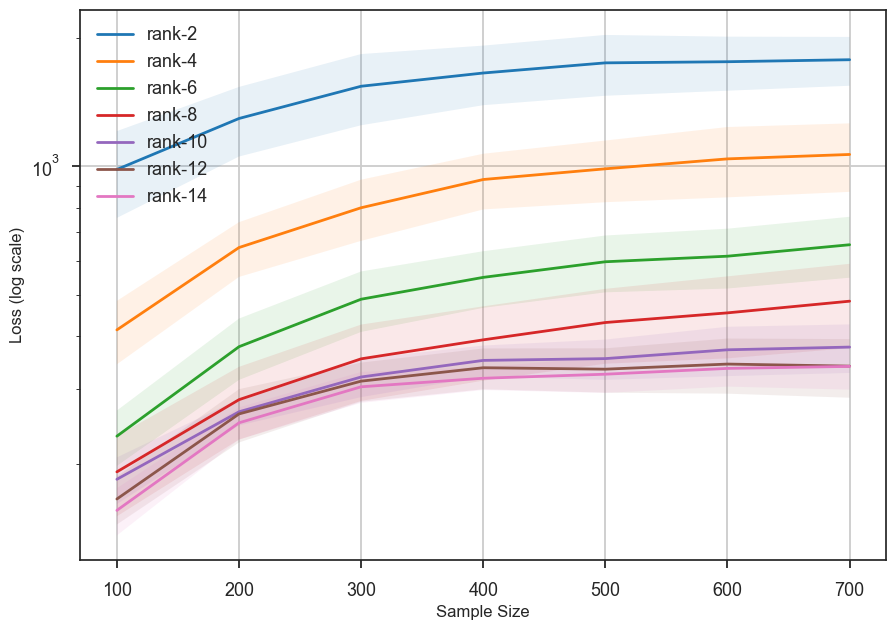

In [35]:
plot_rank(results['train'])

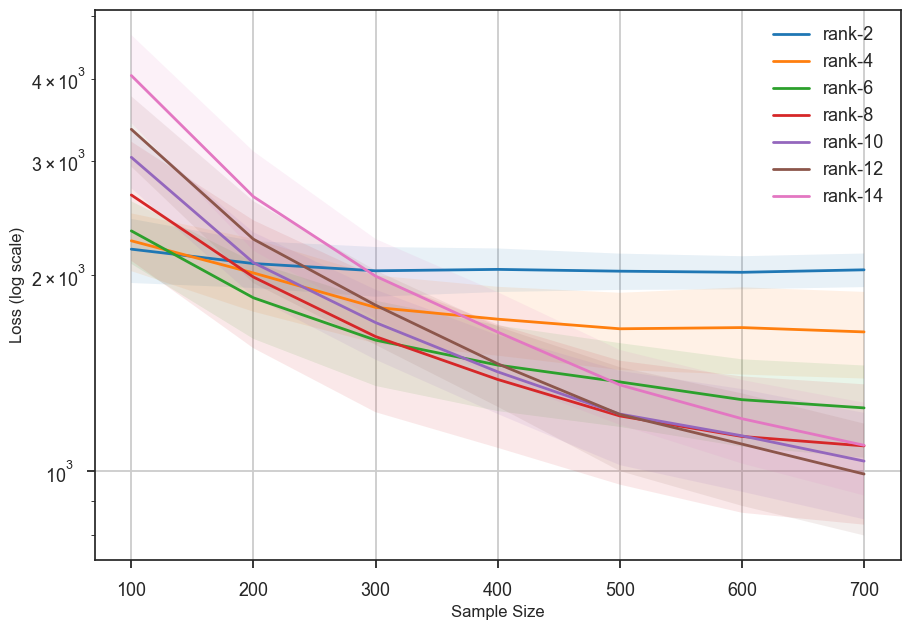

In [36]:
plot_rank(results['test'])

# Plot Generalizations vs. MPS Rank

In [20]:
def filter_sample_data_and_swap_keys(results, train_size=TRAIN_SIZE):
    results_ = {}
    for rank, res in results.items():
        for sample_size, data in res.items():
            if sample_size in train_size:
                results_.setdefault(sample_size, {})[rank] = data
    return results_

results_sample = {k: filter_sample_data_and_swap_keys(results[k]) for k in ['train', 'test']}

In [37]:
def plot_sample(results):
    # converting into a dict
    results = idict2dict(results)
    for sample, res in results.items():
        res = {k: jnp.asarray([i.item() for i in v.values()]) for k,v in res.items()}
        res = jax.tree_map(lambda r: r[~(r>=1e+4)], res)
        mean = jax.tree_map(jnp.mean, res)
        ci = jax.tree_map(lambda x: 1.96 * x / jnp.sqrt(len(res)), 
                          jax.tree_map(jnp.std, res))
        keys, mean = zip(*mean.items())
        _, ci = zip(*ci.items())
        err_l, err_h = zip(*[(m-e, m+e) for m,e in zip(mean, ci)])
        plt.plot(keys, mean, label=f'sample size: {sample}', linewidth=2.5)
        plt.fill_between(keys, err_l, err_h, alpha=0.2)
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.xlabel('MPS rank', fontsize=12)
    plt.ylabel('Loss (log scale)', fontsize=12)
    plt.show()

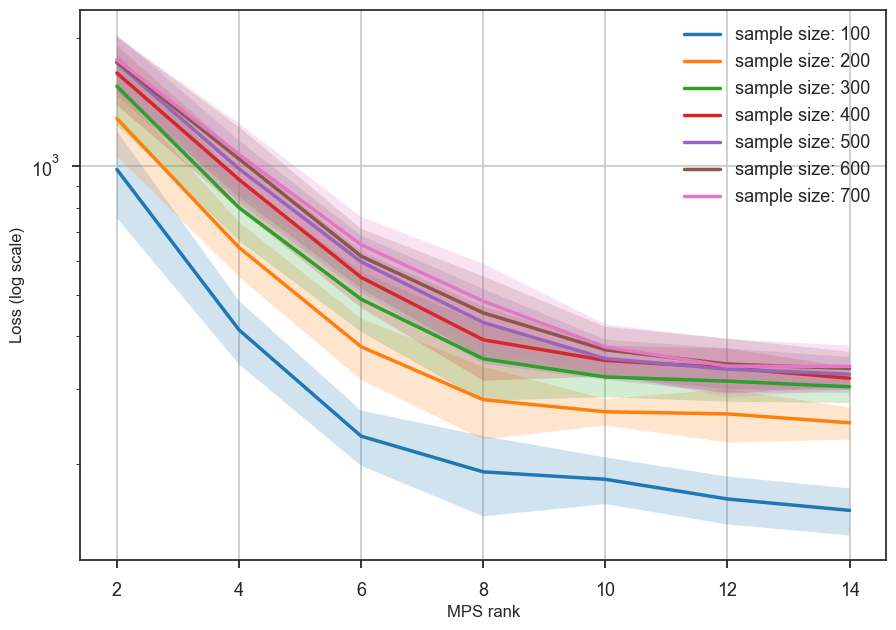

In [38]:
plot_sample(results_sample['train'])

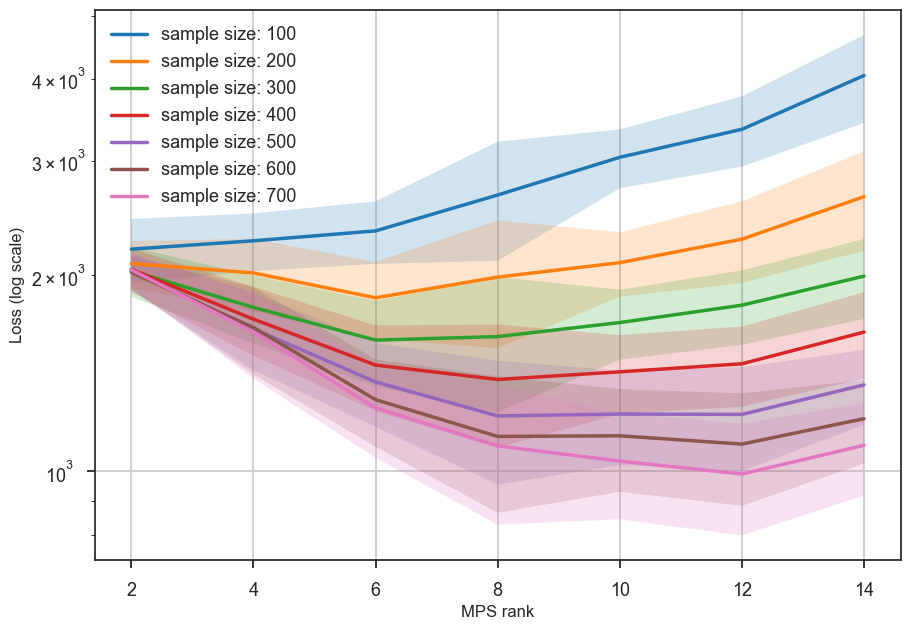

In [39]:
plot_sample(results_sample['test'])